# Data preparation and Visualization 

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
dataset = pd.read_csv('./Irish_Tourism.csv')

In [23]:
dataset.head(10)

,Statistic Label,Quarter,Domestic,Reason for Journey,UNIT,VALUE
0,Number of Trips by Irish Residents,2000Q1,Domestic,All reasons for journey,Thousand,1169.0
1,Number of Trips by Irish Residents,2000Q1,Domestic,Holiday,Thousand,408.0
2,Number of Trips by Irish Residents,2000Q1,Domestic,Business,Thousand,161.0
3,Number of Trips by Irish Residents,2000Q1,Domestic,Visiting friends/relatives,Thousand,468.0
4,Number of Trips by Irish Residents,2000Q1,Domestic,Other reasons,Thousand,132.0
5,Number of Trips by Irish Residents,2000Q1,Outbound,All reasons for journey,Thousand,716.0
6,Number of Trips by Irish Residents,2000Q1,Outbound,Holiday,Thousand,344.0
7,Number of Trips by Irish Residents,2000Q1,Outbound,Business,Thousand,175.0
8,Number of Trips by Irish Residents,2000Q1,Outbound,Visiting friends/relatives,Thousand,142.0
9,Number of Trips by Irish Residents,2000Q1,Outbound,Other reasons,Thousand,54.0


In [24]:
missing_values = dataset.isnull().sum()
print("Missing Values Per Column:\n", missing_values)

Missing Values Per Column:
 Statistic Label        0
Quarter                0
Domestic               0
Reason for Journey     0
UNIT                   0
VALUE                 64
dtype: int64


In [25]:
# using the median approach to fill missing values in Value Column
dataset['VALUE'].fillna(dataset['VALUE'].median(), inplace=True)

/var/folders/3g/lffy_gzj5nqgb76wmktqw4mr0000gn/T/ipykernel_47695/1319762796.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['VALUE'].fillna(dataset['VALUE'].median(), inplace=True)


In [26]:
missing_values = dataset.isnull().sum()
print("Missing Values After Median Approach:\n", missing_values)

Missing Values After Median Approach:
 Statistic Label       0
Quarter               0
Domestic              0
Reason for Journey    0
UNIT                  0
VALUE                 0
dtype: int64


In [27]:
dataset['Date'] = pd.to_datetime(dataset['Quarter'].astype(str))
dataset['Year'] = dataset['Date'].dt.year
dataset['Quarter'] = dataset['Date'].dt.quarter

/var/folders/3g/lffy_gzj5nqgb76wmktqw4mr0000gn/T/ipykernel_47695/550336473.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['Date'] = pd.to_datetime(dataset['Quarter'].astype(str))


In [28]:
seasons = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
dataset['Season'] = dataset['Quarter'].map(seasons)

In [29]:
dataset['VALUE'] = pd.to_numeric(dataset['VALUE'], errors='coerce')

In [32]:
# Trips data
trips_df = dataset[dataset['Statistic Label'].str.contains('Number of Trips')]
trips_pivot = trips_df.pivot_table(
    values='VALUE',
    index=['Year', 'Quarter'],
    columns=['Domestic', 'Reason for Journey'],
    aggfunc='sum'
).reset_index()

In [33]:
# Expenditure data
expenditure_df = dataset[dataset['Statistic Label'].str.contains('Expenditure')]
expenditure_pivot = expenditure_df.pivot_table(
    values='VALUE',
    index=['Year', 'Quarter'],
    columns=['Domestic'],
    aggfunc='sum'
).reset_index()

In [34]:
# Average stay data
stay_df = dataset[dataset['Statistic Label'].str.contains('Average Length')]


In [35]:
# Also calculating the covid period 
covid = dataset['Year'].between(2020, 2021)
dataset.loc[covid & dataset['VALUE'].isna(), 'VALUE'] = dataset.loc[covid, 'VALUE'].mean()

In [36]:
import plotly.express as px

In [37]:
# Overall Trends from 2000 to 2024
fig1 = px.line(
    trips_df[trips_df['Reason for Journey'] == 'All reasons for journey'],
    x='Date',
    y='VALUE',
    color='Domestic',
    title='Travel Trends: Domestic vs Outbound (2000-2024)'
)
fig1.show()

In [38]:
fig2 = px.box(
    trips_df,
    x='Season',
    y='VALUE',
    color='Domestic',
    facet_col='Reason for Journey',
    title='Trip Patterns by Season and Journey Type'
)
fig2.show()

In [39]:
import plotly.graph_objects as go

In [40]:
fig3 = go.Figure()
for travel_type in ['Domestic', 'Outbound']:
    data = expenditure_df[expenditure_df['Domestic'] == travel_type]
    fig3.add_trace(
        go.Scatter(
            x=data['Date'],
            y=data['VALUE'],
            name=travel_type,
            mode='lines+markers'
        )
    )
fig3.update_layout(title='Expenditure Trends Over Time')
fig3.show()

In [41]:
journey_dist = trips_df.pivot_table(
    values='VALUE',
    index='Reason for Journey',
    columns='Domestic',
    aggfunc='mean'
).round(2)

In [42]:
fig4 = px.bar(
    journey_dist,
    barmode='group',
    title='Average Trips by Journey Purpose'
)
fig4.show()

In [43]:
avg_trips = trips_df.groupby('Domestic')['VALUE'].agg(['mean', 'std']).round(2)
print("\nAverage Trips per Quarter:")
print(avg_trips)



Average Trips per Quarter:
            mean     std
Domestic                
Domestic  870.72  869.49
Outbound  680.60  724.75


In [44]:

avg_expenditure = expenditure_df.groupby('Domestic')['VALUE'].agg(['mean', 'std']).round(2)
print("\nAverage Expenditure (Euro Million):")
print(avg_expenditure)


Average Expenditure (Euro Million):
            mean     std
Domestic                
Domestic  163.00  194.03
Outbound  595.97  693.98


In [45]:

seasonal_patterns = trips_df.groupby(['Season', 'Domestic'])['VALUE'].mean().round(2)
print("\nSeasonal Patterns:")
print(seasonal_patterns)


Seasonal Patterns:
Season  Domestic
Autumn  Domestic     793.52
        Outbound     608.13
Spring  Domestic     827.51
        Outbound     736.19
Summer  Domestic    1173.15
        Outbound     842.08
Winter  Domestic     698.51
        Outbound     539.87
Name: VALUE, dtype: float64


In [47]:
print("\nGenerating economic indicators...")
expenditure_by_period = expenditure_df.groupby(['Year', 'Quarter', 'Domestic'])['VALUE'].sum()
trips_by_period = trips_df.groupby(['Year', 'Quarter', 'Domestic'])['VALUE'].sum()
spend_per_trip = (expenditure_by_period / trips_by_period).round(2)


Generating economic indicators...


In [61]:
print("\nAverage Spend per Trip:")
print(spend_per_trip.groupby('Domestic').mean())



Average Spend per Trip:
Domestic
Domestic    0.181556
Outbound    0.853778
Name: VALUE, dtype: float64


In [62]:
# Growth rates
yearly_trips = trips_df.groupby(['Year', 'Domestic'])['VALUE'].sum()
growth_rates = yearly_trips.groupby('Domestic').pct_change() * 100
print("\nYearly Growth Rates (%):")
print(growth_rates.groupby('Domestic').mean().round(2))


Yearly Growth Rates (%):
Domestic
Domestic     5.05
Outbound    12.46
Name: VALUE, dtype: float64


In [48]:
final_df = dataset.copy()
final_df['Spend_Per_Trip'] = final_df.apply(
    lambda x: spend_per_trip.get((x['Year'], x['Quarter'], x['Domestic']), np.nan),
    axis=1
)

In [49]:
for travel_type in ['Domestic', 'Outbound']:
    mask = final_df['Domestic'] == travel_type
    final_df.loc[mask, 'Growth_Rate'] = final_df.loc[mask, 'VALUE'].pct_change() * 100

In [50]:
print("\nFinal Summary Statistics:")
summary_stats = {
    'Total Years': final_df['Year'].nunique(),
    'Total Quarters': final_df['Quarter'].nunique(),
    'Average Domestic Trips': trips_df[trips_df['Domestic'] == 'Domestic']['VALUE'].mean().round(2),
    'Average Outbound Trips': trips_df[trips_df['Domestic'] == 'Outbound']['VALUE'].mean().round(2),
    'Average Domestic Spend': expenditure_df[expenditure_df['Domestic'] == 'Domestic']['VALUE'].mean().round(2),
    'Average Outbound Spend': expenditure_df[expenditure_df['Domestic'] == 'Outbound']['VALUE'].mean().round(2)
}


Final Summary Statistics:


In [51]:
for metric, value in summary_stats.items():
    print(f"{metric}: {value}")

Total Years: 23
Total Quarters: 4
Average Domestic Trips: 870.72
Average Outbound Trips: 680.6
Average Domestic Spend: 163.0
Average Outbound Spend: 595.97


# Machine learning for Data Analytics

In [52]:
final_df.head()

,Statistic Label,Quarter,Domestic,Reason for Journey,UNIT,VALUE,Date,Year,Season,Spend_Per_Trip,Growth_Rate
0,Number of Trips by Irish Residents,1,Domestic,All reasons for journey,Thousand,1169.0,2000-01-01,2000,Winter,0.1,NaN
1,Number of Trips by Irish Residents,1,Domestic,Holiday,Thousand,408.0,2000-01-01,2000,Winter,0.1,-65.098375
2,Number of Trips by Irish Residents,1,Domestic,Business,Thousand,161.0,2000-01-01,2000,Winter,0.1,-60.539216
3,Number of Trips by Irish Residents,1,Domestic,Visiting friends/relatives,Thousand,468.0,2000-01-01,2000,Winter,0.1,190.683230
4,Number of Trips by Irish Residents,1,Domestic,Other reasons,Thousand,132.0,2000-01-01,2000,Winter,0.1,-71.794872


In [53]:
# Data preprocessing for ML
expenditure_data = final_df[final_df['Statistic Label'].str.contains('Expenditure')].copy()
expenditure_data['Month'] = pd.DatetimeIndex(expenditure_data['Date']).month
expenditure_data['Previous_Quarter_Value'] = expenditure_data.groupby('Domestic')['VALUE'].shift(1)
expenditure_data = expenditure_data.dropna()

In [54]:
# Preparing features and target
X_exp = expenditure_data[['Year', 'Month', 'Quarter', 'Previous_Quarter_Value']]
y_exp = expenditure_data['VALUE']

In [55]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [56]:
# Splitting the dataset
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(
    X_exp, y_exp, test_size=0.2, random_state=42
)

In [57]:
# Scaling the features
scaler = StandardScaler()
X_train_exp_scaled = scaler.fit_transform(X_train_exp)
X_test_exp_scaled = scaler.transform(X_test_exp)

In [58]:
print("Training XGBoost model for expenditure prediction...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

Training XGBoost model for expenditure prediction...


In [59]:
xgb_model.fit(X_train_exp_scaled, y_train_exp)
xgb_predictions = xgb_model.predict(X_test_exp_scaled)

In [60]:
# Model performance
print("\nXGBoost Model Performance:")
print(f"R2 Score: {r2_score(y_test_exp, xgb_predictions):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_exp, xgb_predictions)):.3f}")
print(f"MAE: {mean_absolute_error(y_test_exp, xgb_predictions):.3f}")


XGBoost Model Performance:
R2 Score: 0.047
RMSE: 564.271
MAE: 339.160


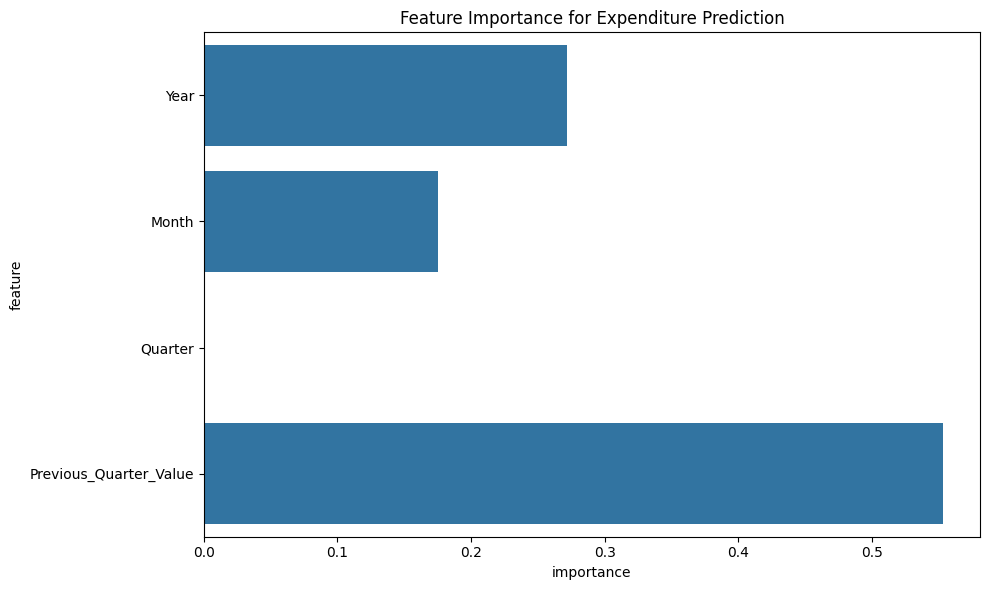

In [61]:
plt.figure(figsize=(10, 6))
importance_df = pd.DataFrame({
    'feature': X_exp.columns,
    'importance': xgb_model.feature_importances_
})
sns.barplot(data=importance_df, x='importance', y='feature')
plt.title('Feature Importance for Expenditure Prediction')
plt.tight_layout()
plt.show()

In [62]:
# Preparing time series data
trips_data = final_df[
    (final_df['Statistic Label'].str.contains('Number of Trips')) &
    (final_df['Reason for Journey'] == 'All reasons for journey')
].copy()

In [63]:
# Separating domestic and outbound
domestic_trips = trips_data[trips_data['Domestic'] == 'Domestic'].set_index('Date')['VALUE']
outbound_trips = trips_data[trips_data['Domestic'] == 'Outbound'].set_index('Date')['VALUE']


In [64]:
# SARIMA model for domestic trips
print("\nFitting SARIMA model for domestic trips...")
sarima_domestic = SARIMAX(
    domestic_trips,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 4)
)


Fitting SARIMA model for domestic trips...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [65]:
sarima_domestic_fit = sarima_domestic.fit(disp=False)

In [66]:
domestic_forecast = sarima_domestic_fit.forecast(steps=4)
print("\nDomestic Travel Forecast (Next 4 quarters):")
print(domestic_forecast)


Domestic Travel Forecast (Next 4 quarters):
90    5171.733213
91    3921.728828
92    3630.128226
93    4380.807662
Name: predicted_mean, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



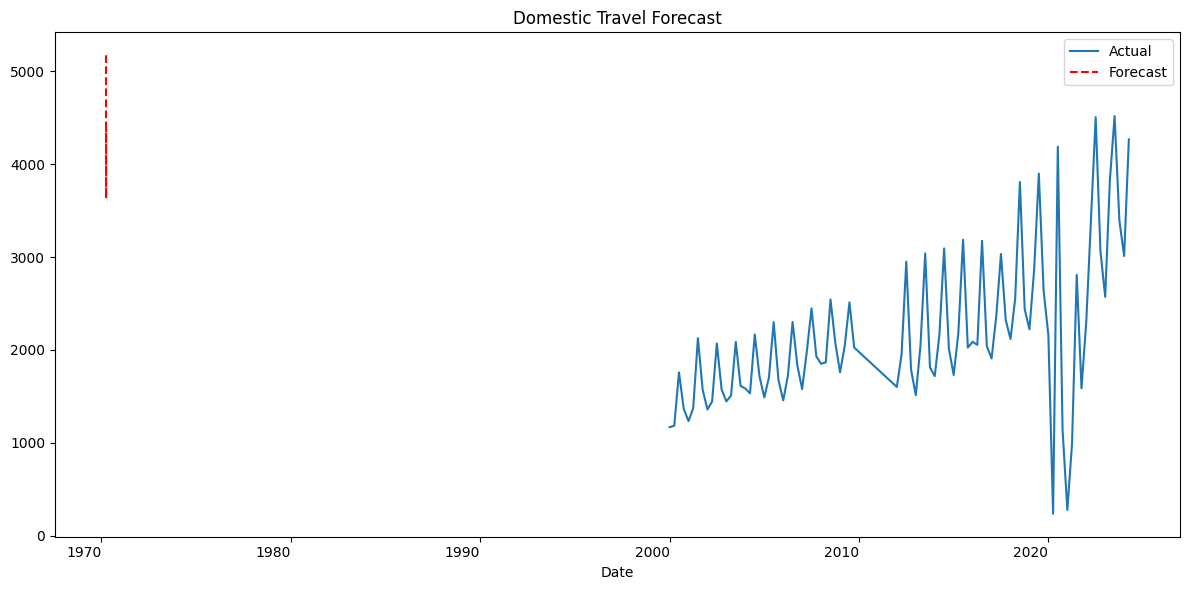

In [67]:
plt.figure(figsize=(12, 6))
domestic_trips.plot(label='Actual')
domestic_forecast.plot(label='Forecast', style='r--')
plt.title('Domestic Travel Forecast')
plt.legend()
plt.tight_layout()
plt.show()

In [68]:
# Random Forest for Stay Duration Prediction
stay_data = final_df[
    final_df['Statistic Label'].str.contains('Average Length')
].copy()



In [69]:
stay_data.head()

,Statistic Label,Quarter,Domestic,Reason for Journey,UNIT,VALUE,Date,Year,Season,Spend_Per_Trip,Growth_Rate
1800,Average Length of Stay by Irish Residents,1,Domestic,All reasons for journey,Nights per Trip,3.1,2000-01-01,2000,Winter,0.1,-99.672304
1801,Average Length of Stay by Irish Residents,1,Domestic,Holiday,Nights per Trip,3.1,2000-01-01,2000,Winter,0.1,0.000000
1802,Average Length of Stay by Irish Residents,1,Domestic,Business,Nights per Trip,3.2,2000-01-01,2000,Winter,0.1,3.225806
1803,Average Length of Stay by Irish Residents,1,Domestic,Visiting friends/relatives,Nights per Trip,2.7,2000-01-01,2000,Winter,0.1,-15.625000
1804,Average Length of Stay by Irish Residents,1,Domestic,Other reasons,Nights per Trip,3.9,2000-01-01,2000,Winter,0.1,44.444444


In [70]:
scaler = StandardScaler()
stay_data['VALUE_standardized'] = scaler.fit_transform(stay_data[['VALUE']].fillna(0))

In [71]:
X_stay = stay_data[['Year', 'Quarter', 'VALUE_standardized']]
y_stay = stay_data['VALUE']


In [72]:
X_train_stay, X_test_stay, y_train_stay, y_test_stay = train_test_split(
    X_stay, y_stay, test_size=0.2, random_state=42
)


In [73]:
print("\nTraining Random Forest for stay duration prediction...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42
)


Training Random Forest for stay duration prediction...


In [74]:
rf_model.fit(X_train_stay, y_train_stay)
rf_predictions = rf_model.predict(X_test_stay)

In [75]:
print("\nStay Duration Model Performance:")
print(f"R2 Score: {r2_score(y_test_stay, rf_predictions):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_stay, rf_predictions)):.3f}")
print(f"MAE: {mean_absolute_error(y_test_stay, rf_predictions):.3f}")


Stay Duration Model Performance:
R2 Score: 1.000
RMSE: 0.176
MAE: 0.022


Text(0, 0.5, 'Predicted Values')

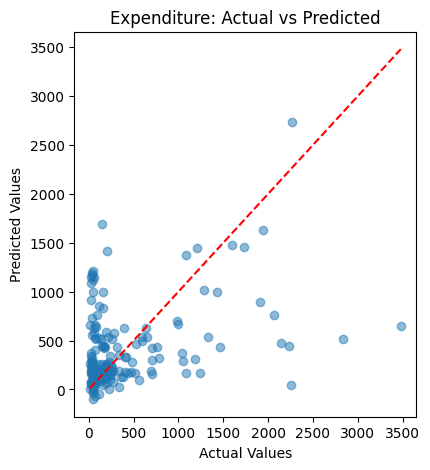

In [76]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.scatter(y_test_exp, xgb_predictions, alpha=0.5)
plt.plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], 'r--')
plt.title('Expenditure: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

Text(0, 0.5, 'Predicted Values')

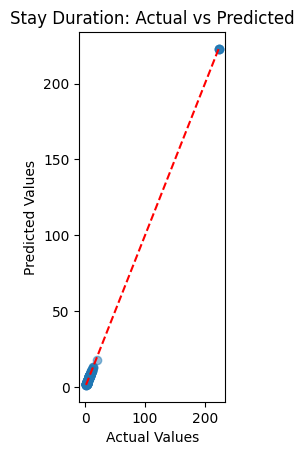

In [96]:
# Stay duration predictions
plt.subplot(132)
plt.scatter(y_test_stay, rf_predictions, alpha=0.5)
plt.plot([y_test_stay.min(), y_test_stay.max()], [y_test_stay.min(), y_test_stay.max()], 'r--')
plt.title('Stay Duration: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

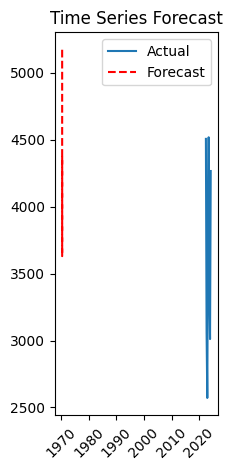

In [78]:
# Time series forecast
plt.subplot(133)
plt.plot(domestic_trips.index[-8:], domestic_trips[-8:], label='Actual')
plt.plot(domestic_forecast.index, domestic_forecast.values, 'r--', label='Forecast')
plt.title('Time Series Forecast')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()